## 计算QM9数据集中分子在x、y、z三个轴上的最大直径

### 导入相关库

In [24]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# 设置字体 - 使用英文避免中文字体问题
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 设置图表样式
plt.style.use('default')
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 12

### 分析分子的相关函数

In [25]:
def calculate_molecule_diameter(coords, atoms_channel, padding_index=999):
    """
    Calculate molecular diameter along x, y, z axes
    
    Args:
        coords: molecular coordinates (N, 3)
        atoms_channel: atom types (N,)
        padding_index: padding index to ignore invalid atoms
    
    Returns:
        dict: dictionary containing x, y, z axis diameters
    """
    # Filter out padding atoms
    valid_mask = atoms_channel != padding_index
    valid_coords = coords[valid_mask]
    
    if len(valid_coords) == 0:
        return {"x": 0.0, "y": 0.0, "z": 0.0}
    
    # Calculate min and max coordinates for each axis
    min_coords = torch.min(valid_coords, dim=0).values
    max_coords = torch.max(valid_coords, dim=0).values
    
    # Calculate diameter (max - min)
    diameters = max_coords - min_coords
    
    return {
        "x": diameters[0].item(),
        "y": diameters[1].item(), 
        "z": diameters[2].item()
    }

def analyze_qm9_diameters(data_dir="dataset/data", split="train", max_samples=None):
    """
    Analyze molecular diameters in QM9 dataset
    
    Args:
        data_dir: data directory
        split: dataset split ("train", "val", "test")
        max_samples: maximum number of samples to analyze, None for all
    """
    # Load data
    data_path = os.path.join(data_dir, "qm9", f"{split}_data.pth")
    if not os.path.exists(data_path):
        print(f"Error: Data file not found {data_path}")
        return None
    
    print(f"Loading {split} dataset...")
    data = torch.load(data_path, weights_only=False)
    
    if max_samples:
        data = data[:max_samples]
        print(f"Analyzing first {max_samples} molecules only")
    
    print(f"Starting analysis of {len(data)} molecules...")
    
    # Store all molecular diameters
    all_diameters = []
    
    # Iterate through all molecules
    for i, sample in enumerate(tqdm(data, desc=f"Analyzing {split} molecules")):
        coords = sample["coords"]
        atoms_channel = sample["atoms_channel"]
        
        # Calculate current molecule diameter
        diameters = calculate_molecule_diameter(coords, atoms_channel)
        all_diameters.append(diameters)
    
    # Convert to numpy array for analysis
    diameters_array = np.array([[d["x"], d["y"], d["z"]] for d in all_diameters])
    
    # Calculate statistics
    print(f"\n=== QM9 {split} Dataset Molecular Diameter Statistics ===")
    print(f"Number of molecules analyzed: {len(all_diameters)}")
    
    for axis in ["x", "y", "z"]:
        axis_idx = {"x": 0, "y": 1, "z": 2}[axis]
        axis_diameters = diameters_array[:, axis_idx]
        
        print(f"\n{axis.upper()} axis:")
        print(f"  Min: {axis_diameters.min():.4f}")
        print(f"  Max: {axis_diameters.max():.4f}")
        print(f"  Mean: {axis_diameters.mean():.4f}")
        print(f"  Median: {np.median(axis_diameters):.4f}")
        print(f"  Std: {axis_diameters.std():.4f}")
    
    # Calculate overall max diameter (max of three axes)
    max_diameters = np.max(diameters_array, axis=1)
    print(f"\nOverall max diameter (max of three axes):")
    print(f"  Min: {max_diameters.min():.4f}")
    print(f"  Max: {max_diameters.max():.4f}")
    print(f"  Mean: {max_diameters.mean():.4f}")
    print(f"  Median: {np.median(max_diameters):.4f}")
    print(f"  Std: {max_diameters.std():.4f}")
    
    # Find molecule with max diameter
    max_idx = np.argmax(max_diameters)
    print(f"\nMolecule with max diameter (index {max_idx}):")
    print(f"  X-axis diameter: {diameters_array[max_idx, 0]:.4f}")
    print(f"  Y-axis diameter: {diameters_array[max_idx, 1]:.4f}")
    print(f"  Z-axis diameter: {diameters_array[max_idx, 2]:.4f}")
    print(f"  Max diameter: {max_diameters[max_idx]:.4f}")
    
    return diameters_array, max_diameters

### 绘图相关的函数

In [26]:
def plot_diameter_distributions(all_results):
    """
    Plot molecular diameter distributions
    
    Args:
        all_results: dictionary containing all dataset results
    """
    # Prepare data
    all_data = []
    for split, (diameters_array, max_diameters) in all_results.items():
        for i, max_diameter in enumerate(max_diameters):
            all_data.append({
                'split': split,
                'max_diameter': max_diameter,
                'x_diameter': diameters_array[i, 0],
                'y_diameter': diameters_array[i, 1],
                'z_diameter': diameters_array[i, 2]
            })
    
    df = pd.DataFrame(all_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('QM9 Dataset Molecular Diameter Distribution Analysis', fontsize=16, fontweight='bold')
    
    # 1. Max diameter distribution histogram (by dataset split)
    axes[0, 0].hist([df[df['split']=='train']['max_diameter'], 
                     df[df['split']=='val']['max_diameter'],
                     df[df['split']=='test']['max_diameter']], 
                    bins=50, alpha=0.7, label=['Train', 'Val', 'Test'])
    axes[0, 0].set_xlabel('Max Diameter (Å)')
    axes[0, 0].set_ylabel('Number of Molecules')
    axes[0, 0].set_title('Max Diameter Distribution by Dataset Split')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Axis diameter distribution histogram
    axes[0, 1].hist(df['x_diameter'], bins=50, alpha=0.7, label='X-axis', color='red')
    axes[0, 1].hist(df['y_diameter'], bins=50, alpha=0.7, label='Y-axis', color='green')
    axes[0, 1].hist(df['z_diameter'], bins=50, alpha=0.7, label='Z-axis', color='blue')
    axes[0, 1].set_xlabel('Diameter (Å)')
    axes[0, 1].set_ylabel('Number of Molecules')
    axes[0, 1].set_title('Diameter Distribution by Axis')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Max diameter boxplot (by dataset split)
    split_data = [df[df['split']==split]['max_diameter'] for split in ['train', 'val', 'test']]
    axes[0, 2].boxplot(split_data, labels=['Train', 'Val', 'Test'])
    axes[0, 2].set_ylabel('Max Diameter (Å)')
    axes[0, 2].set_title('Max Diameter Boxplot by Dataset Split')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Axis diameter boxplot
    axis_data = [df['x_diameter'], df['y_diameter'], df['z_diameter']]
    axes[1, 0].boxplot(axis_data, labels=['X-axis', 'Y-axis', 'Z-axis'])
    axes[1, 0].set_ylabel('Diameter (Å)')
    axes[1, 0].set_title('Diameter Boxplot by Axis')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Cumulative distribution function
    sorted_diameters = np.sort(df['max_diameter'])
    cumulative_prob = np.arange(1, len(sorted_diameters) + 1) / len(sorted_diameters)
    axes[1, 1].plot(sorted_diameters, cumulative_prob, linewidth=2)
    axes[1, 1].axhline(y=0.95, color='red', linestyle='--', alpha=0.7, label='95th percentile')
    axes[1, 1].axhline(y=0.99, color='orange', linestyle='--', alpha=0.7, label='99th percentile')
    axes[1, 1].set_xlabel('Max Diameter (Å)')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].set_title('Cumulative Distribution Function')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Configuration setting validation
    current_grid_size = 20 * 0.25  # grid_dim * resolution
    suggested_grid_size_95 = np.percentile(df['max_diameter'], 95)
    suggested_grid_size_99 = np.percentile(df['max_diameter'], 99)
    
    axes[1, 2].bar(['Current\\n(20×0.25)', '95th percentile\\nSuggestion', '99th percentile\\nSuggestion', 'Actual Max'], 
                   [current_grid_size, suggested_grid_size_95, suggested_grid_size_99, df['max_diameter'].max()],
                   color=['red', 'orange', 'yellow', 'green'], alpha=0.7)
    axes[1, 2].set_ylabel('Grid Size (Å)')
    axes[1, 2].set_title('Configuration Setting Validation')
    axes[1, 2].grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate([current_grid_size, suggested_grid_size_95, suggested_grid_size_99, df['max_diameter'].max()]):
        axes[1, 2].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('qm9_diameter_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df

def plot_detailed_analysis(df):
    """
    Plot detailed analysis
    
    Args:
        df: DataFrame containing all data
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('QM9 Dataset Molecular Diameter Detailed Analysis', fontsize=16, fontweight='bold')
    
    # 1. Density plot
    for split in ['train', 'val', 'test']:
        split_data = df[df['split'] == split]['max_diameter']
        split_data.plot.kde(ax=axes[0, 0], label=f'{split} set', alpha=0.7)
    
    axes[0, 0].set_xlabel('Max Diameter (Å)')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Max Diameter Density Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Scatter plot: X-axis vs Y-axis diameter
    scatter = axes[0, 1].scatter(df['x_diameter'], df['y_diameter'], 
                                c=df['max_diameter'], cmap='viridis', alpha=0.6, s=1)
    axes[0, 1].set_xlabel('X-axis Diameter (Å)')
    axes[0, 1].set_ylabel('Y-axis Diameter (Å)')
    axes[0, 1].set_title('X-axis vs Y-axis Diameter Scatter Plot')
    plt.colorbar(scatter, ax=axes[0, 1], label='Max Diameter (Å)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Diameter correlation heatmap
    correlation_matrix = df[['x_diameter', 'y_diameter', 'z_diameter', 'max_diameter']].corr()
    im = axes[1, 0].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1, 0].set_xticks(range(len(correlation_matrix.columns)))
    axes[1, 0].set_yticks(range(len(correlation_matrix.columns)))
    axes[1, 0].set_xticklabels(['X-axis', 'Y-axis', 'Z-axis', 'Max Diameter'])
    axes[1, 0].set_yticklabels(['X-axis', 'Y-axis', 'Z-axis', 'Max Diameter'])
    axes[1, 0].set_title('Diameter Correlation Heatmap')
    
    # Add correlation coefficient labels
    for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            text = axes[1, 0].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                                  ha="center", va="center", color="black", fontweight='bold')
    
    # 4. Percentile analysis
    percentiles = [50, 75, 90, 95, 99, 99.5, 99.9]
    percentile_values = [np.percentile(df['max_diameter'], p) for p in percentiles]
    
    axes[1, 1].bar(range(len(percentiles)), percentile_values, 
                   color=['lightblue', 'skyblue', 'blue', 'darkblue', 'purple', 'red', 'darkred'])
    axes[1, 1].set_xlabel('Percentile (%)')
    axes[1, 1].set_ylabel('Max Diameter (Å)')
    axes[1, 1].set_title('Percentile Analysis')
    axes[1, 1].set_xticks(range(len(percentiles)))
    axes[1, 1].set_xticklabels(percentiles)
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(percentile_values):
        axes[1, 1].text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('qm9_detailed_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


### 运行

开始分析QM9数据集分子直径...

分析 train 数据集
Loading train dataset...
Starting analysis of 97734 molecules...


Analyzing train molecules: 100%|██████████| 97734/97734 [00:07<00:00, 13390.15it/s]



=== QM9 train Dataset Molecular Diameter Statistics ===
Number of molecules analyzed: 97734

X axis:
  Min: 0.0301
  Max: 10.3183
  Mean: 4.4916
  Median: 4.4511
  Std: 1.0942

Y axis:
  Min: 0.0000
  Max: 11.4391
  Mean: 5.2739
  Median: 5.1587
  Std: 1.0931

Z axis:
  Min: 0.0000
  Max: 10.0368
  Mean: 4.1983
  Median: 4.2699
  Std: 1.2966

Overall max diameter (max of three axes):
  Min: 1.4361
  Max: 11.4391
  Mean: 5.7999
  Median: 5.6865
  Std: 0.8798

Molecule with max diameter (index 39224):
  X-axis diameter: 2.8513
  Y-axis diameter: 11.4391
  Z-axis diameter: 2.2934
  Max diameter: 11.4391

分析 val 数据集
Loading val dataset...
Starting analysis of 20042 molecules...


Analyzing val molecules: 100%|██████████| 20042/20042 [00:01<00:00, 14075.67it/s]



=== QM9 val Dataset Molecular Diameter Statistics ===
Number of molecules analyzed: 20042

X axis:
  Min: 0.0771
  Max: 10.0219
  Mean: 4.4899
  Median: 4.4541
  Std: 1.0819

Y axis:
  Min: 0.0000
  Max: 11.8271
  Mean: 5.2704
  Median: 5.1611
  Std: 1.0957

Z axis:
  Min: 0.0000
  Max: 9.7145
  Mean: 4.1964
  Median: 4.2616
  Std: 1.2984

Overall max diameter (max of three axes):
  Min: 1.8741
  Max: 11.8271
  Mean: 5.7975
  Median: 5.6784
  Std: 0.8757

Molecule with max diameter (index 7845):
  X-axis diameter: 1.5421
  Y-axis diameter: 11.8271
  Z-axis diameter: 1.7709
  Max diameter: 11.8271

分析 test 数据集
Loading test dataset...
Starting analysis of 13055 molecules...


Analyzing test molecules: 100%|██████████| 13055/13055 [00:00<00:00, 14286.53it/s]



=== QM9 test Dataset Molecular Diameter Statistics ===
Number of molecules analyzed: 13055

X axis:
  Min: 0.0425
  Max: 9.8766
  Mean: 4.4796
  Median: 4.4416
  Std: 1.0918

Y axis:
  Min: 1.2802
  Max: 11.1337
  Mean: 5.2723
  Median: 5.1423
  Std: 1.0931

Z axis:
  Min: 0.0069
  Max: 9.8686
  Mean: 4.2028
  Median: 4.2726
  Std: 1.2779

Overall max diameter (max of three axes):
  Min: 1.2802
  Max: 11.1337
  Mean: 5.7958
  Median: 5.6787
  Std: 0.8744

Molecule with max diameter (index 9534):
  X-axis diameter: 2.2680
  Y-axis diameter: 11.1337
  Z-axis diameter: 1.8350
  Max diameter: 11.1337

汇总统计
train 数据集最大直径范围: 1.4361 - 11.4391
val 数据集最大直径范围: 1.8741 - 11.8271
test 数据集最大直径范围: 1.2802 - 11.1337

整个QM9数据集:
  总分子数: 130831
  最大直径范围: 1.2802 - 11.8271
  平均最大直径: 5.7991
  中位数最大直径: 5.6841
  95%分位数: 7.4748
  99%分位数: 8.4610


/tmp/ipykernel_681896/3555239046.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 2].boxplot(split_data, labels=['Train', 'Val', 'Test'])
/tmp/ipykernel_681896/3555239046.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(axis_data, labels=['X-axis', 'Y-axis', 'Z-axis'])


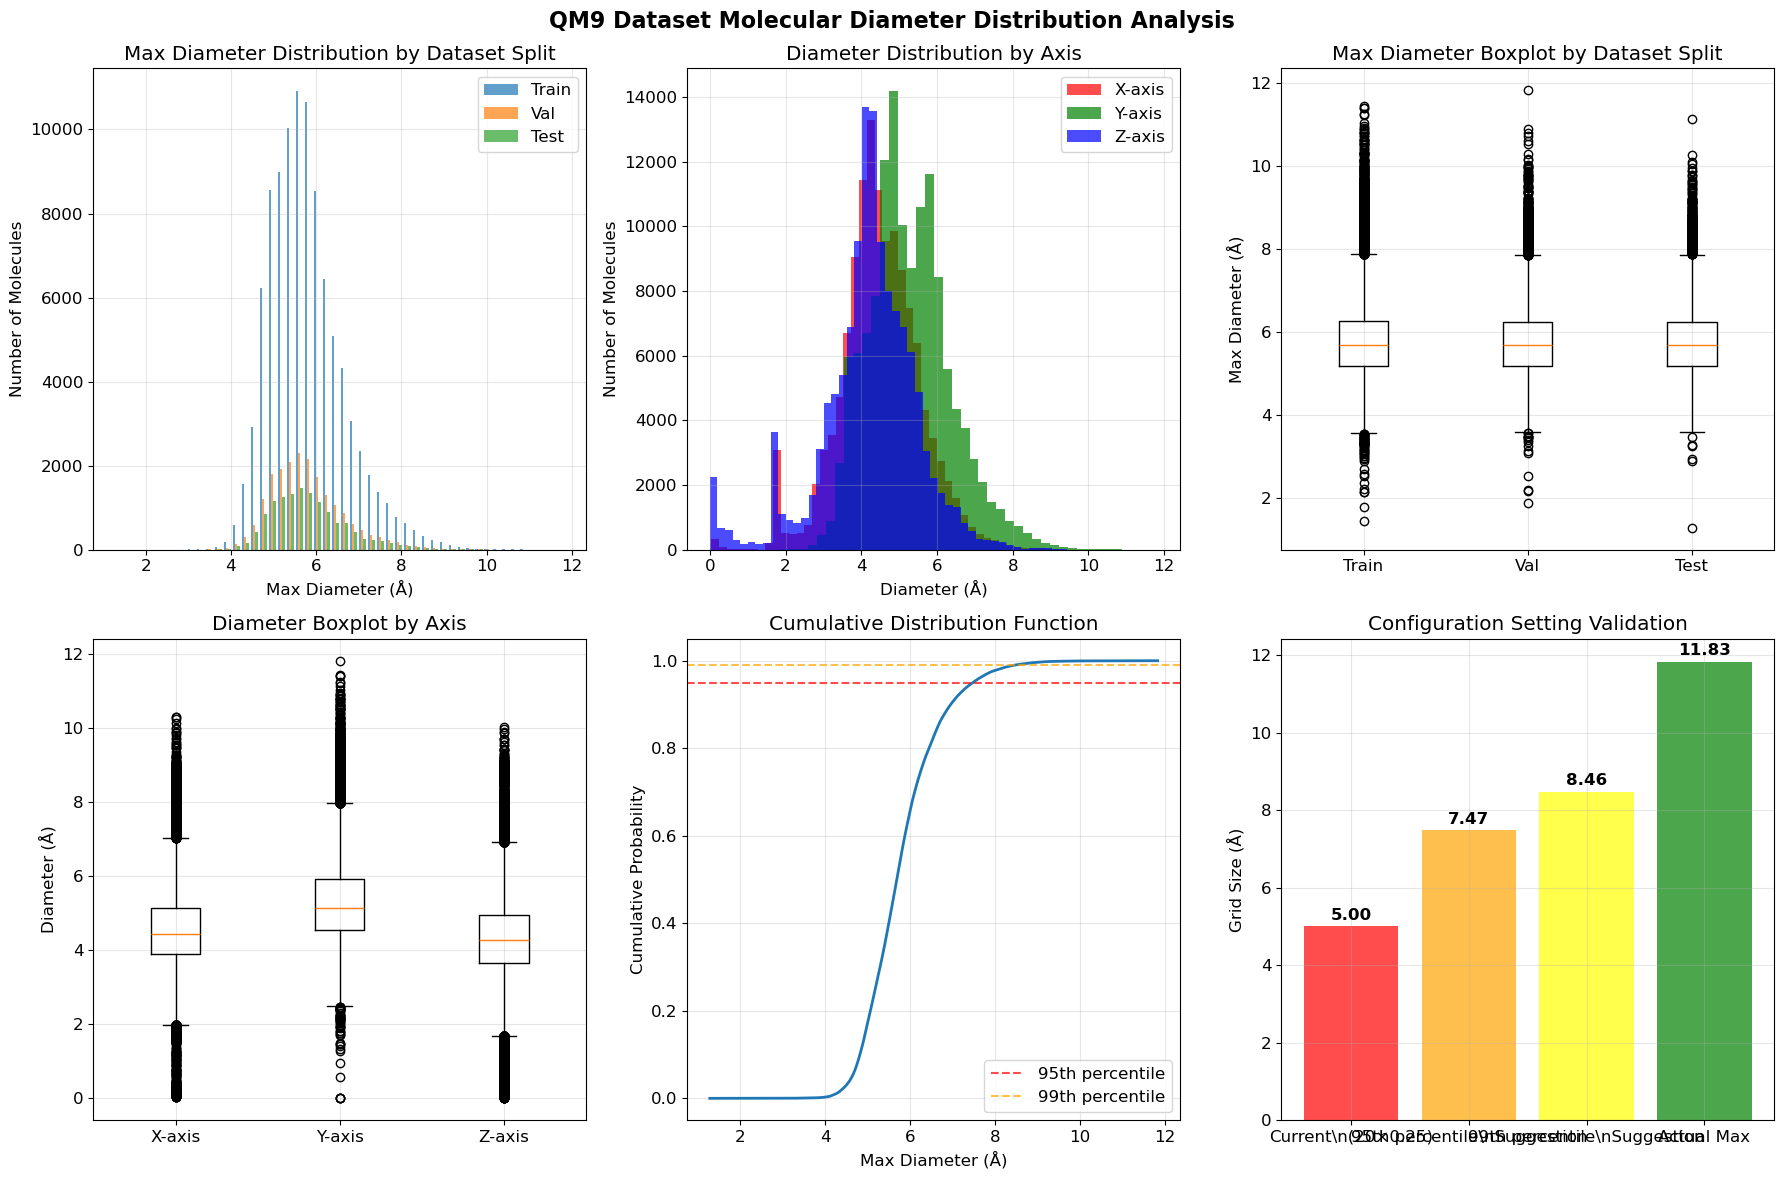

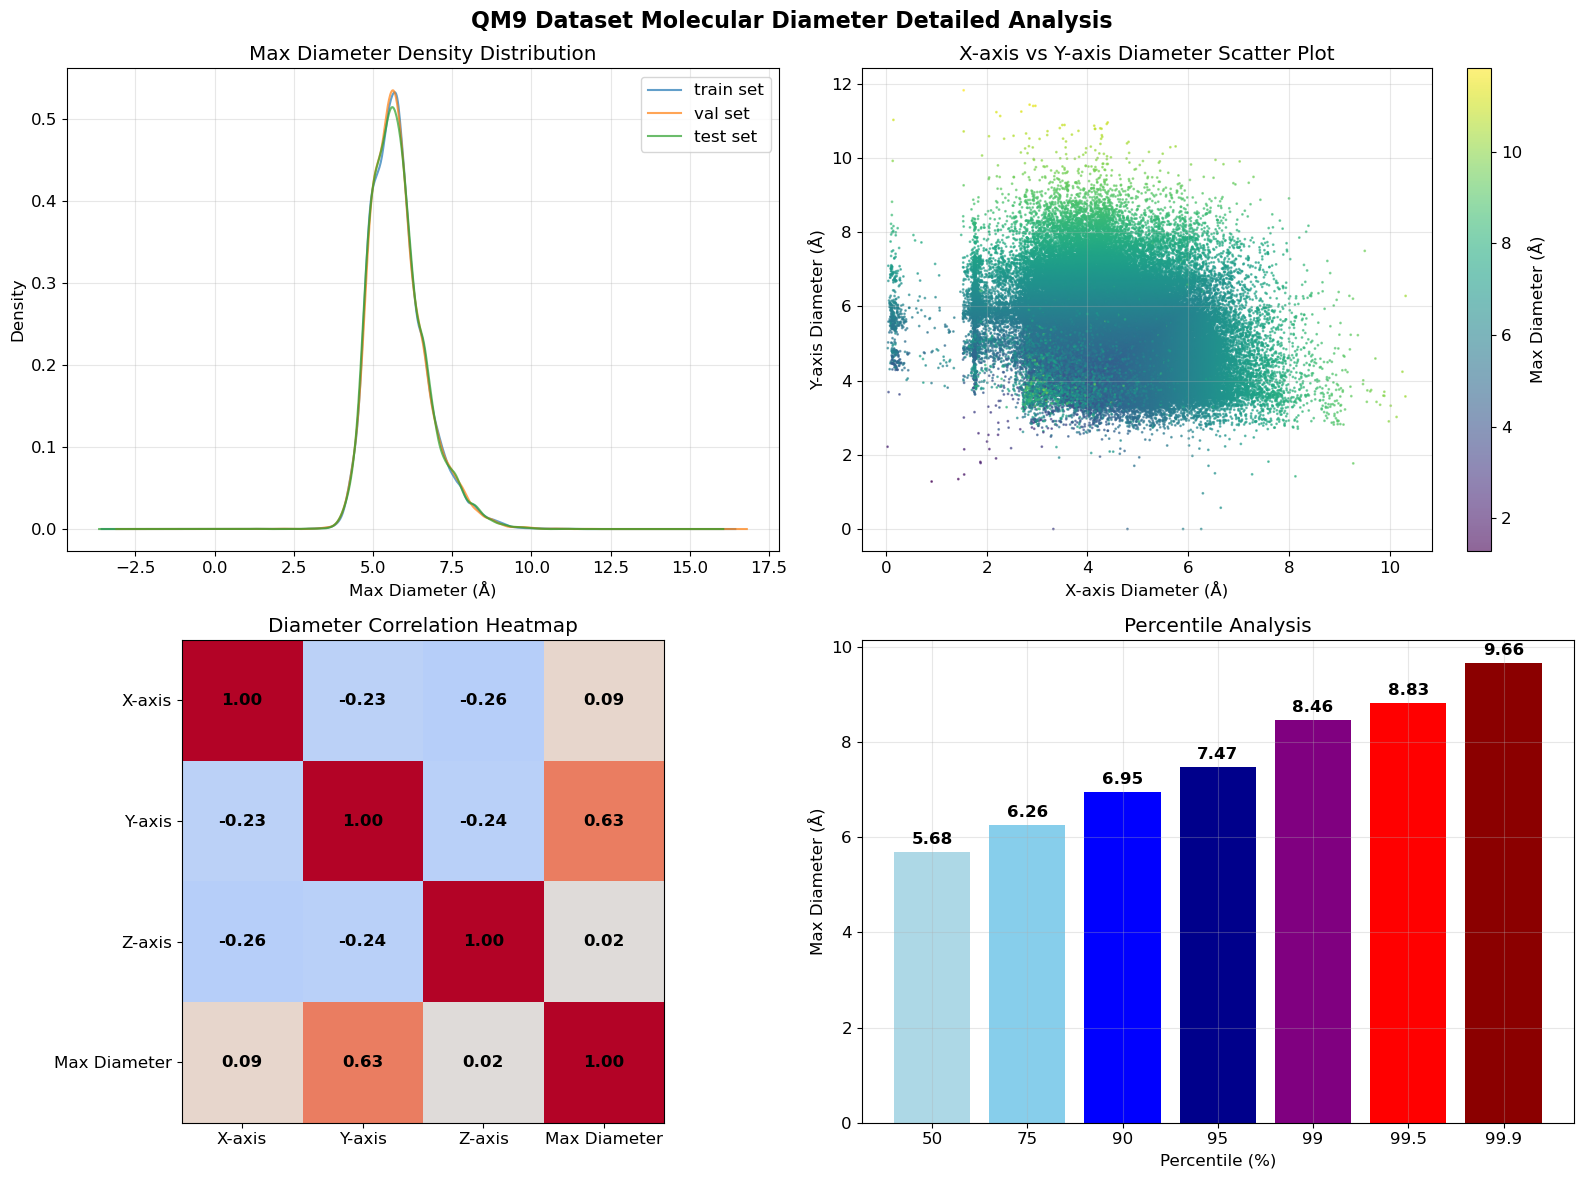

In [27]:
print("开始分析QM9数据集分子直径...")
    
# 分析所有数据集分割
all_results = {}
    
for split in ["train", "val", "test"]:
    print(f"\n{'='*50}")
    print(f"分析 {split} 数据集")
    print(f"{'='*50}")
        
    # 分析完整数据集
    result = analyze_qm9_diameters(split=split)
    if result is not None:
        all_results[split] = result
    
# 汇总统计
print(f"\n{'='*50}")
print("汇总统计")
print(f"{'='*50}")
    
all_max_diameters = []
for split, (diameters_array, max_diameters) in all_results.items():
    all_max_diameters.extend(max_diameters)
    print(f"{split} 数据集最大直径范围: {max_diameters.min():.4f} - {max_diameters.max():.4f}")
    
all_max_diameters = np.array(all_max_diameters)
print(f"\n整个QM9数据集:")
print(f"  总分子数: {len(all_max_diameters)}")
print(f"  最大直径范围: {all_max_diameters.min():.4f} - {all_max_diameters.max():.4f}")
print(f"  平均最大直径: {all_max_diameters.mean():.4f}")
print(f"  中位数最大直径: {np.median(all_max_diameters):.4f}")
print(f"  95%分位数: {np.percentile(all_max_diameters, 95):.4f}")
print(f"  99%分位数: {np.percentile(all_max_diameters, 99):.4f}")

# 绘制主要分布图
df = plot_diameter_distributions(all_results)
    
# 绘制详细分析图
plot_detailed_analysis(df)